# Regresión logística
En este ejercicio exploraremos el uso de Regresión logística. Primero programarás los elementos necesarios para optimizar la función por descenso de gradiente y después usaremos las librerias de scikit-learn para encontrar la solución. 

Regresión logística nos sirve para resolver problemas de <b>clasificación</b>, esto consiste en utilizar datos para estimar un valor discreto que será asignado a una categoría, en el siguiente código nos enfocaremos especificamente en clasificación 
binaria.

Para entender mejor los conceptos utilizaremos el ["Breast cancer wisconsin (diagnostic) dataset"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer). Este dataset contiene distintos atributos para determinar si un tumor es maligno(0) o benigno(1). Antes de empezar analizaremos el dataset.

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import numpy as np

dataset = load_breast_cancer()
# Podemos visualizar los atributos del dataset y la dimensionalidad de los datos
print("Nobres de las columnas:", dataset.keys())
print("Matriz de datos (X.shape -> NxD): ", dataset['data'].shape)
print("Cantidad de datos(N): ", dataset['target'].shape)
print("Clases: 0-> %s, 1-> %s" %(dataset.target_names[0], dataset.target_names[1]))

Nobres de las columnas: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
Matriz de datos (X.shape -> NxD):  (569, 30)
Cantidad de datos(N):  (569,)
Clases: 0-> malignant, 1-> benign


In [2]:
# Podemos visualizar los nombres de los datos para decidir que atributos utilizar.
# En este caso utilizaremos la textura y el perímetro del tumor para generar la predicción.
print(dataset['feature_names'][[21, 22]])
print(dataset['target_names']) 

# Haremos el split de los datos y a partir de ahora solo usaremos
# el conjunto de entrenamiento para encontrar nuestro modelo
data_train, data_test, target_train, target_test = train_test_split(
    dataset['data'][:, [21, 22]], 
    dataset['target'], 
    test_size=0.25
)

['worst texture' 'worst perimeter']
['malignant' 'benign']


In [3]:
# TODO: Imprime la cantidad de puntos que serán dedicados para entrenamiento y
# para prueba
# ====== Start of solution =====
print(f"Entrenamiento - {len(data_train)} datapoints")
print(f"Evaluación - {len(data_test)} datapoints")
# ====== End of solution =====

# Es bueno saber como es la distribución de los datos
# Incluyendo cuantos ejemplos son benignos y malignos
malignant_idcs = np.where(target_train == 0)
benign_idcs = np.where(target_train == 1)

# TODO: Imprime la cantidad de puntos que son malignos y benignos
# ====== Start of solution =====
malignant = len(data_train[malignant_idcs])
benign = len(data_train[benign_idcs])
# ====== End of solution =====
print(malignant, benign, malignant + benign)
print(data_train.shape, target_train.shape)

Entrenamiento - 426 datapoints
Evaluación - 143 datapoints
159 267 426
(426, 2) (426,)


## Visualización de datos
Antes de resolver cualquier problema es necesario entenderlo, para los problemas de aprendizaje máquina una de las herramientas mas importantes para comprender mejor a que nos enfrentamos es el visualizar los datos.

In [4]:
malignant_entries = data_train[malignant_idcs]
target = np.expand_dims(target_train, -1)
target = target[malignant_idcs]
print(malignant_entries.shape, target.shape)

(159, 2) (159, 1)


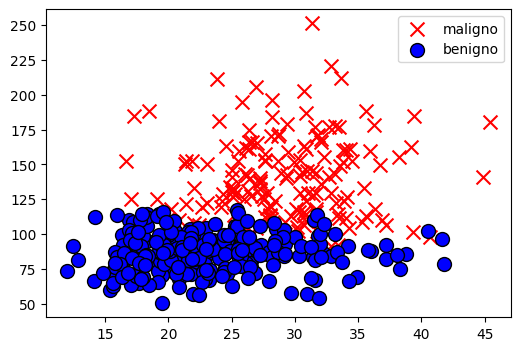

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))

# Pintaremos los que tienen etiqueta 0 y etiqueta 1 de distinto color
# Muestra un máximo de dp_to_plot puntos para cada clase
dp_to_plot = 100

# Grafica los datos malignos
malignant_entries = data_train[malignant_idcs]
ax.scatter(
    # TODO: Ingresa los datos a graficar
    # ====== Start of solution =====
    x=malignant_entries[:, 0],
    y=malignant_entries[:, 1],
    # ====== End of solution =====
    s=100,
    color="r", 
    marker="x",
    label="maligno"
)

# Grafica los datos benignos
benign_entries = data_train[benign_idcs]
ax.scatter(
    # TODO: Ingresa los datos a graficar
    # ====== Start of solution =====
    x=benign_entries[:, 0],
    y=benign_entries[:, 1],
    # ====== End of solution =====
    s=100,
    color="b", 
    edgecolor='black',
    marker="o",
    label="benigno"
)
plt.legend()
plt.show()


## La función sigmoide
Podemos aplicar un modelo de regresión logística para encontrar el límite de separación que nos permita clasificar nuevos tumores, a partir de los datos de entrenamiento.Recordamos la función logística vista en clase:

$ h_w(z) = \frac{1}{1 + e^{-z}}$

En la siguiente celda, visualiza la función logística.

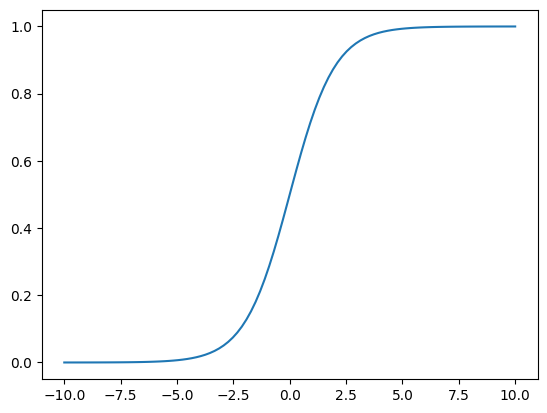

In [6]:
def logistic(z):
    # TODO: Calcula la hipótesis h(z)
    # ====== Start of solution =====
    h = 1 / (1 + np.exp(-z))
    # ====== End of solution =====
    return h

x = np.linspace(-10, 10, 100)
y = logistic(x)
# TODO: Grafica la función logística
# ====== Start of solution =====
plt.plot(x, y)
# ====== End of solution =====

Si queremos aprender un modelo de regresión logística, debemos encontrar los parámetros w que minimizen la función de costo. En regresión logística, el modelo de decisión consiste en:

$ h_w(X) = \frac{1}{1 + e^{-Xw}}$

Donde:
- $X$ corresponde a los datos proporcionados
- $h_w(X)$ es la predicción o hipótesis de nuestro modelo de regresión logística

Recuerda que para realizar las operaciones de manera correcta $X$ debe estar en su notación aumentada, es decir, tiene un uno adicional por cada datapoint para que se pueda añadir el sesgo: $X \in \mathbb{R}^ {D+1 \times N }$. Por lo tanto, los pesos tienen este parámetro adicional también $ w \in R^{D+1} $

En este problema $D = 2$ ya que estamos utilizando el perímetro y la textura del tumor para hacer la predición.

TODO: En la siguiente celda, calcula las predicciones de regresión logística para una inicialización aleatoria de los pesos $w$

In [7]:
n = len(data_train)
ones = np.ones(shape=(n, 1))
aug_data_train = np.concatenate((ones, data_train), axis=1)
print(aug_data_train.shape)

(426, 3)


(426, 3)
(426,)


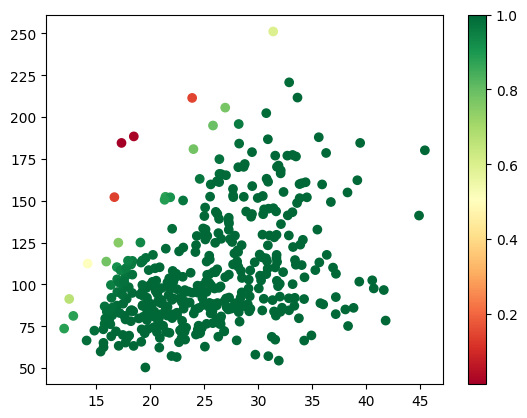

In [8]:
# Inicializando W
w = np.random.uniform(low=-1, high=1, size=(3,))

# TODO: Genera el dataset de entrenamiento aumentado
# para el conjunto de datos de entrenamiento data_train
# aug_data_train = ?
# ====== Start of solution =====
n = len(data_train)
ones = np.ones(shape=(n, 1))
aug_data_train = np.concatenate((ones, data_train), axis=1)
# ====== End of solution =====

# TODO: Calcula el valor de z/ la combinación lineal de los pesos y datos de entrenamiento
# ====== Start of solution =====
z = aug_data_train @ w
# ====== End of solution =====
pred = logistic(z)

print(aug_data_train.shape)
print(pred.shape)

# Graficamos los puntos para visualizar la predicción de nuestro modelo actualmente
plt.scatter(aug_data_train[:, 1],aug_data_train[:, 2], c=pred, cmap="RdYlGn")
plt.colorbar()

## Función de costo
Como vemos, al inicializarse los pesos, el modelo clasifica la mayoría de los puntos como benignos(0), sin embargo una vez optimizada la función, el modelo aprende el valor de los pesos óptimos dados los datos de entrenamiento. Para optimizar los pesos necesitamos aplicar descenso de gradiente usando la función de costo.

En clase vimos que la función de costo que se utiliza para problemas de clasificación binaria, se conoce como binary cross entropy loss (BCE)

$ L(h_w(x), y) = - y \log(h_w(x)) - (1 - y)\log(1 - h_w(x)) $

La funcion de logaritmo $\log{x}$ tiende al infinito cuando $x=0$. Para evitar esto, es común agregar un valor muy pequeño $\epsilon$ al valor dentro del logaritmo.

$ L(h_w(x), y) = - y \log(h_w(x) + \epsilon) - (1 - y)\log(1 - h_w(x) + \epsilon) $

Termina el método para calcular la función de costo correspondiente.

In [11]:
def bce_loss(X, w, y):
    """
        X: datos en notación aumentada,
        w: pesos del modelo
        y: etiquetas de los datos
    """
    eps = 1e-5 
    # TODO: Calcula la función de costo
    # Nota - suma la variable eps dentro del logaritmo 
    # para evitar errores por números muy cercanos a log de 0
    # ====== Start of solution =====
    z = X @ w
    h = logistic(z)
    loss = -y * np.log(h + eps)- (1 - y) * np.log(1 - h + eps)
    # ====== End of solution ======
    return loss.mean(axis=0)

loss = bce_loss(aug_data_train, w, target_train)
print("Costo: %.3f" %loss)

Costo: 3.099


## Optmización
Podemos resolver el problema anterior utilizando descenso por gradiente. Para ello, requeriríamos sacar el gradiente de la función de costo con respecto a los pesos e iterar como en el ejercicio de regresión lineal. Es decir, necesitaríamos el gradiente del BCE loss, por lo tanto no podemos usar la función anteriormente calculada ya que utilizamos un loss diferente (MSE).

En esta ocasión resolveremos el problema con la librería de scikit-learn. Completa donde se indique.

0.9370629370629371 0.9370629370629371


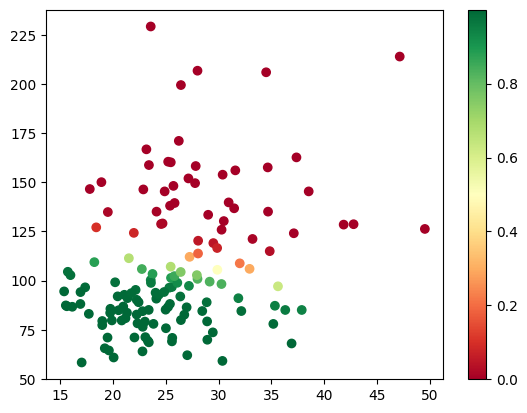

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(data_train, target_train)

# Entrenamiento
prediction = model.predict(data_train)
train_accuracy = np.mean(prediction == target_train)

# Validacion
proba = model.predict_proba(data_test)[:, 1]
preds_test = model.predict(data_test)
acc = model.score(data_test, target_test)
test_accuracy =  np.mean(preds_test == target_test)

# ====== End of solution =====
print(acc, test_accuracy)

# Graficamos los puntos para visualizar la predicción de nuestro modelo
plt.scatter(data_test[:, 0],data_test[:, 1], c=proba, cmap="RdYlGn")
plt.colorbar()

En la celda anterior, calculamos una predicción para cada punto de evaluación. Específicamente, el color de cada punto indica una probabilidad de que el tumor correspondiente sea benigno. 
<b>TODO: Contesta las siguientes preguntas</b> 
- ¿Por qué es útil predecir la probabilidad de que el tumor sea benigno en lugar de decir con certeza qué tipo de tumor es? 
- Intuitivamente ¿Qué necesitarías para tener una predicción más acertada?
- Menciona otro problema real que se pueda resolver con un modelo de clasificación.